# House Prices - Advanced Regression Techniques - code2
Kaggle dataset : [https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data]

### Sobre os dados:
**File descriptions:**
* **train.csv** - the training set
* **test.csv** - the test set
* **data_description.txt** - full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here\
* **sample_submission.csv** - a benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms


In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression as LR
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor as KNN

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error  as MSE
from sklearn.metrics import  r2_score


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau,TerminateOnNaN


from tensorflow.keras.optimizers import AdamW, Nadam




import warnings
#alertas
warnings.simplefilter(action='ignore', category=FutureWarning)

data=pd.read_csv('train.csv')


In [51]:
# 1 - Separando colunas numéricas
df=data.select_dtypes(include=['number']) #1460x38(novo dataframe)
#df.isnull().sum().sort_values(ascending=False)

# 2 - Eliminar coluna que tem mais que 10% dos dados nulos.
col_10null = df.columns[(df.isnull().sum()/df.shape[0]) > 0.1]
df = df.drop(col_10null,axis=1)

In [78]:
# 3 - Examples |Options

#ex1) To replace Null values with the median Values 
df1=df
null_coll = df1.columns[df1.isnull().any()].tolist()
for i in null_coll:
   df1[i]=df1[i].fillna(df1[i].median())

#ex2) To replace by random sample
df2=df
np.random.seed(42)  
null_coll = df2.columns[df2.isnull().any()].tolist()
for i in null_coll:
    N=df2[i].isnull().sum()
    sample = np.random.choice(df2[i].dropna(), size=N, replace=False)
    df2.loc[df2[i].isnull(), 'GarageYrBlt'] = sample

#ex3) filter by correlaction
df3=df
null_coll = df3.columns[df3.isnull().any()].tolist()
for i in null_coll:
   df3[i]=df3[i].fillna(df3[i].median())

#df3=df
df_corr = df3.corr()
corr_order = df_corr['SalePrice'].sort_values(ascending=False)
filter_corr = corr_order[(corr_order.abs() > 0.05) & (corr_order.index != 'SalePrice')]

# save filter
filter03 = ['Id'] + filter_corr.index.tolist()
dffilter03 = pd.DataFrame({'filter': filter03 })
# # Salvar em arquivo CSV
dffilter03.to_csv('filter03.csv', index=False)

df3=df3[['Id'] + filter_corr.index.tolist()+['SalePrice']]
df3.shape

(1460, 30)

### Base de treino e teste

### Modelos
1. Regressão linear
2. Árvore de Regressão
3. KNeighborsRegressor

/home/akel/anaconda3/envs/data_science/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


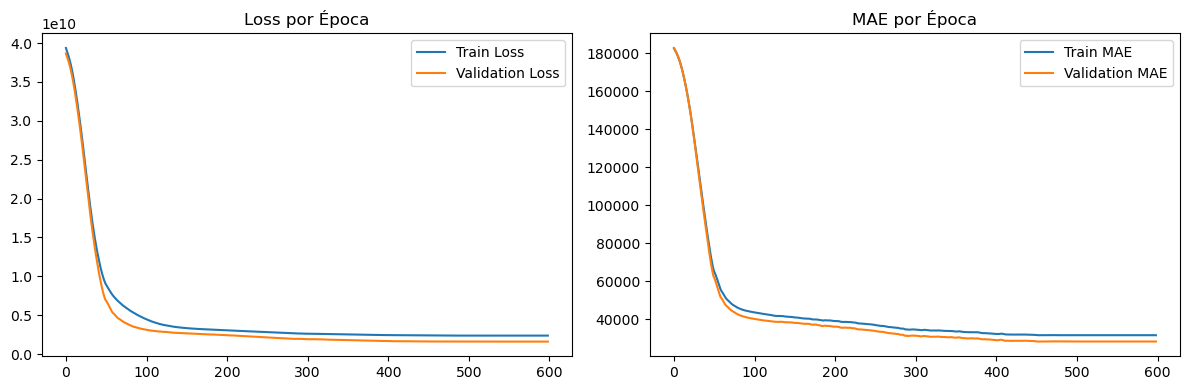

In [84]:
# Base de treino e teste
from sklearn.model_selection import train_test_split

x = df1.drop('SalePrice',axis=1)
y = df1.SalePrice

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

#1 Regressão Linear
mod_LR = LR().fit(x_train, y_train)

y_lr = mod_LR.predict(x_test)

# Arvore de regressão
mod_tree = tree.DecisionTreeRegressor(random_state=42).fit(x_train, y_train)
y_tree   =mod_tree.predict(x_test)

#K-vizinhos mais próximos
mod_knn = KNN(n_neighbors=2).fit(x_train, y_train)
y_knn   = mod_knn.predict(x_test)

from tensorflow.keras.layers import Dropout

# Neural Networks
mod_NN = Sequential([
    Dense(64, input_dim=x_train.shape[1], activation='relu'),  
    Dense(1) 
])
from tensorflow.keras.layers import Dropout

#mod_NN.add(Dropout(0.1))  

mod_NN .compile(optimizer=AdamW(weight_decay=1e-4), 
              loss='mean_squared_error',
              metrics=['mae'])

cb = [EarlyStopping(patience=100, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5)]


temp = mod_NN.fit(
    x_train, y_train,
    batch_size=128,  
    epochs=600,
    validation_split=0.2,
    callbacks=cb,
    verbose=0);


y_nn = mod_NN .predict(x_test)

plt.figure(figsize=(12, 4))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(temp.history['loss'], label='Train Loss')
plt.plot(temp.history['val_loss'], label='Validation Loss')
plt.title('Loss por Época')
plt.legend()

# Gráfico de MAE
plt.subplot(1, 2, 2)
plt.plot(temp.history['mae'], label='Train MAE')
plt.plot(temp.history['val_mae'], label='Validation MAE')
plt.title('MAE por Época')
plt.legend()

plt.tight_layout()
plt.show()

### Avaliando Erro dos modelos

In [85]:
print('===== Sumary Tests ====')
print('\nLinear Regression Model')
print(f'MAE: {MAE(y_test,y_lr):3f}')
print(f'MSE: {MSE(y_test,y_lr):3f}')
print(f"Score(R²): {mod_LR.score(x_test, y_test):.3f}")

print('\nDecision Tree Regression Model')
print(f'MAE: {MAE(y_test,y_tree):3f}')
print(f'MSE: {MSE(y_test,y_tree):3f}')
print(f"Score(R²): {mod_tree.score(x_test, y_test):.3f}")

print('\nk-nearest neighbors Model')
print(f'MAE: {MAE(y_test,y_knn):3f}')
print(f'MSE: {MSE(y_test,y_knn):3f}')
print(f"Score(R²): {mod_knn.score(x_test, y_test):.3f}")

print('\nNeural Networks')
print(f'MAE: {MAE(y_test,y_nn):3f}')
print(f'MSE: {MSE(y_test,y_nn):3f}')
print(f"Score(R²): {r2_score(y_test, y_nn):.3f}")

===== Sumary Tests ====

Linear Regression Model
MAE: 23899.102077
MSE: 1565904387.532156
Score(R²): 0.787

Decision Tree Regression Model
MAE: 27436.209544
MSE: 2157243065.470954
Score(R²): 0.706

k-nearest neighbors Model
MAE: 32832.423237
MSE: 2697627184.795643
Score(R²): 0.633

Neural Networks
MAE: 31668.472656
MSE: 2504171776.000000
Score(R²): 0.659


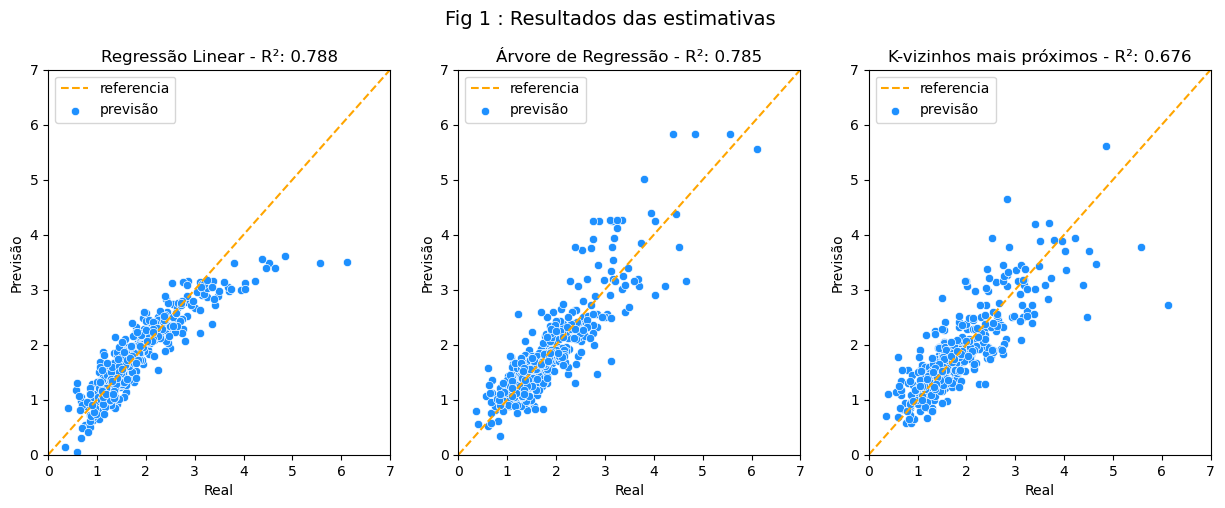

In [200]:
# Plotagem
fig, ax = plt.subplots(ncols=3,figsize=(15,5))
fig.suptitle('Fig 1 : Resultados das estimativas', fontsize=14,y=1);

D=100000

sns.scatterplot(x=y_test/D, y=y_lr/D, ax=ax[0], color='dodgerblue',label='previsão')
ax[0].plot([0,70],[0,70],'--',color='orange',label='referencia')
ax[0].set(xlim=(0, 7),ylim=(0, 7))
ax[0].set_title(f"Regressão Linear - R²: {mod_LR.score(x_test, y_test):.3f}")
ax[0].set_xlabel('Real')
ax[0].set_ylabel('Previsão')
ax[0].legend()

sns.scatterplot(x=y_test/D, y=y_tree/D, ax=ax[1], color='dodgerblue',label='previsão')
ax[1].plot([0,70],[0,70],'--',color='orange',label='referencia')

ax[1].set(xlim=(0, 7),ylim=(0, 7))
ax[1].set_title(f'Árvore de Regressão - R²: {mod_tree.score(x_test, y_test):.3f}')
ax[1].set_xlabel('Real')
ax[1].set_ylabel('Previsão')
ax[1].legend()

sns.scatterplot(x=y_test/D, y=y_knn/D, ax=ax[2], color='dodgerblue',label='previsão')
ax[2].plot([0,70],[0,70],'--',color='orange',label='referencia')
ax[2].set(xlim=(0, 7),ylim=(0, 7))
ax[2].set_title(f'K-vizinhos mais próximos - R²: {mod_knn.score(x_test, y_test):.3f}')
ax[2].set_xlabel('Real')
ax[2].set_ylabel('Previsão')
ax[2].legend()

plt.show()

## Previsão para base de teste para Kaggle


In [159]:
# #to media data
# df_test=pd.read_csv('test.csv');
# print("Colunas com valores nulos:", df_test.shape)

# #1) separar variaves numéricas
# df_test=df_test.select_dtypes(include=['number']) 
# # 2) Remove column that has more than 10% of null data.
# col_10null = df_test.columns[(df_test.isnull().sum()/df_test.shape[0]) > 0.1]
# df_test = df_test.drop(col_10null,axis=1)

# # 3) Replace for median in null data
# null_coll = df_test.columns[df_test.isnull().any()].tolist()
# for i in null_coll:
#    df_test[i]=df_test[i].fillna(df_test[i].median())
# print("Colunas com valores nulos:", null_coll)

# # 4) Run Linear Model
# y_lr = mod_LR.predict(df_test)

# # 5) save result
# df_test['SalePrice'] = y_lr

# s = df_test[['Id','SalePrice']]
# #s.to_csv('solution_011.csv',index=False)
# print("Colunas com valores nulos:", s.shape)

In [8]:
# #To Sample data
# df_test=pd.read_csv('test.csv');
# print("Colunas com valores nulos:", df_test.shape)

# #1) separar variaves numéricas
# df_test=df_test.select_dtypes(include=['number']) 
# # 2) Remove column that has more than 10% of null data.
# col_10null = df_test.columns[(df_test.isnull().sum()/df_test.shape[0]) > 0.1]
# df_test = df_test.drop(col_10null,axis=1)

# # 3) Replace sample
# np.random.seed(42)  
# null_coll = df_test.columns[df_test.isnull().any()].tolist()
# for i in null_coll:
#     N=df_test[i].isnull().sum()
#     sample = np.random.choice(df_test[i].dropna(), size=N, replace=False)
#     df_test.loc[df_test[i].isnull(), 'GarageYrBlt'] = sample

# # 4) Run Linear Model
# y_lr = mod_LR.predict(df_test)

# # 5) save result
# df_test['SalePrice'] = y_lr

# s = df_test[['Id','SalePrice']]
# #s.to_csv('solution_02.csv',index=False)
# print("Colunas com valores nulos:", s.shape)

In [184]:
#To Sample data
df_test=pd.read_csv('test.csv');
print("Colunas com valores nulos:", df_test.shape)

#1) Separate numeric variables.
df_test=df_test.select_dtypes(include=['number']) 
# 2) Remove column that has more than 10% of null data.
col_10null = df_test.columns[(df_test.isnull().sum()/df_test.shape[0]) > 0.1]
df_test = df_test.drop(col_10null,axis=1)

# 3) filter by correlaction ( Columns with correlation>0.3 in saleprice)

null_coll = df_test.columns[df_test.isnull().any()].tolist()
for i in null_coll:
   df_test[i]=df_test[i].fillna(df_test[i].median())

filter_corr=pd.read_csv('filter03.csv');
colls=filter_corr['filter'].to_list()
df_test=df_test[colls]

# # # 4) Run Linear Model
y_lr = mod_LR.predict(df_test)

# # # 5) save result
df_test['SalePrice'] = y_lr

s = df_test[['Id','SalePrice']]
#s.to_csv('solution_03.csv',index=False)
df_test.shape

Colunas com valores nulos: (1459, 80)
Colunas com valores nulos: ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']


(1459, 30)

In [142]:
df_test

,Id,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,MasVnrArea,Fireplaces,GarageYrBlt,BsmtFinSF1,WoodDeckSF,2ndFlrSF,OpenPorchSF
0,1461,5,896,1.0,730.0,882.0,896,1,5,1961,1961,0.0,0,1961.0,468.0,140,0,0
1,1462,6,1329,1.0,312.0,1329.0,1329,1,6,1958,1958,108.0,0,1958.0,923.0,393,0,36
2,1463,5,1629,2.0,482.0,928.0,928,2,6,1997,1998,0.0,1,1997.0,791.0,212,701,34
3,1464,6,1604,2.0,470.0,926.0,926,2,7,1998,1998,20.0,1,1998.0,602.0,360,678,36
4,1465,8,1280,2.0,506.0,1280.0,1280,2,5,1992,1992,0.0,0,1992.0,263.0,0,0,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,4,1092,0.0,0.0,546.0,546,1,5,1970,1970,0.0,0,1979.0,0.0,0,546,0
1455,2916,4,1092,1.0,286.0,546.0,546,1,6,1970,1970,0.0,0,1970.0,252.0,0,546,24
1456,2917,5,1224,2.0,576.0,1224.0,1224,1,7,1960,1996,0.0,1,1960.0,1224.0,474,0,0
1457,2918,5,970,0.0,0.0,912.0,970,1,6,1992,1992,0.0,0,1979.0,337.0,80,0,32
